In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import cm
sns.set_style('ticks')

In [17]:
pd.read_csv('test/pdb_data_no_dups.csv').to_pickle('test/pdb_data_no_dups.pickle')
pd.read_csv('test/pdb_data_seq.csv').to_pickle('test/pdb_data_seq.pickle')

In [19]:
df_dup_raw = pd.read_pickle('test/pdb_data_no_dups.pickle')
df_seq_raw = pd.read_pickle('test/pdb_data_seq.pickle')

In [31]:
merged_df = pd.merge(df_dup_raw,df_seq_raw, on = 'structureId',how='inner')

In [81]:
missing_df = pd.DataFrame(merged_df.isnull().sum().sort_values(ascending=False)/merged_df.shape[0] * 100).reset_index()
missing_df.columns = ['Name', 'Missingness(%)']
missing_df

,Name,Missingness(%)
0,crystallizationMethod,33.194382
1,crystallizationTempK,32.569739
2,phValue,27.688693
3,pdbxDetails,18.185542
4,densityMatthews,17.298986
5,densityPercentSol,17.272880
6,publicationYear,12.233073
7,macromoleculeType_y,7.592078
8,macromoleculeType_x,7.592078
9,resolution,4.597909


### Publications since 1968

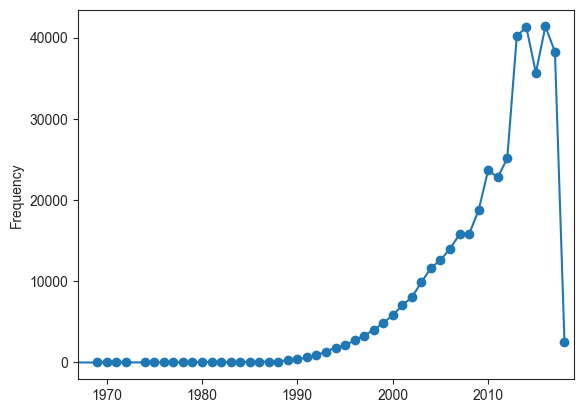

In [137]:
pub_df = merged_df.dropna(subset='publicationYear')
pub_df_x = pub_df.publicationYear.value_counts().sort_index().index
pub_df_y = pub_df.publicationYear.value_counts().sort_index().values
plt.plot(pub_df_x, pub_df_y, marker='o', linestyle='-')
plt.xlim(1967,2019)
plt.ylabel('Frequency')
plt.show()

### pH

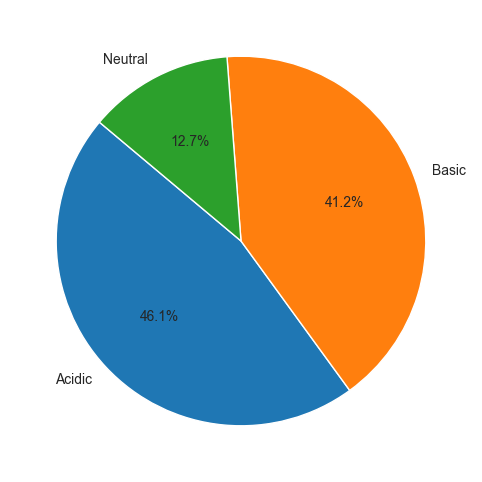

In [178]:
merged_df['Acid_or_base'] = merged_df['phValue'].apply(lambda x: 'Acidic' if x < 7 else 'Basic' if x > 7 else 'Neutral')
ph_df = merged_df.dropna(subset='phValue')
acid_base_counts = ph_df['Acid_or_base'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(acid_base_counts, labels=acid_base_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [172]:
acid_base_counts

Acid_or_base
Acid       157133
Base       140369
Neutral     43192
Name: count, dtype: int64